# **Agent 2 : un bras mécanique attrape une des trois boites**

# Initialisation du notebook

In [ ]:
!pip install gymnasium pybullet stable-baselines3
!pip install tensorboard
!pip install imageio imageio-ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [ ]:
import gymnasium as gym
import numpy as np
import pybullet as p
import pybullet_data
from gymnasium import spaces

from stable_baselines3 import SAC
from stable_baselines3.her.her_replay_buffer import HerReplayBuffer
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
import os

from IPython.display import HTML
from IPython.display import Video
import time
import imageio
from IPython.display import Video

import cv2
import numpy as np


In [ ]:
# pour stocker les vidéos durant l'entrainement, debug
video_folder = "logs/videos/"
os.makedirs(video_folder, exist_ok=True)

# sauvegarde du model
version="1-2"
save_model_path="modelSAC3BoiteGripperV"+version


# Environnement

## Description de l’environnement

L’environnement est constitué d’un plan (z=0), d’un bras panda (https://robodk.com/robot/fr/Franka/Emika-Panda)  fixe et des trois cubes de 4 cm de couleur rouge, bleu et verte.  
Le bras est positionné vers le haut légèrement plié avec le gripper qui pointe vers la bas. Ses angles de mouvement ont été limités.   
Le robot a des paramètres différents en fonction de la phase :   

*   La vélocité et la réactivité pour avoir des mouvements plus ou moins amples

*   Le gripper, bloqué en position ouverte, fermée ou libre.

### Objectif
Le bras reçoit un id (0, 1, 2) d'une boîte, il doit descendre, attraper la boîte et la lever au-dessus de 12 cm et la relâcher.   
Les positions de l’effecteur et du centre de la boîte (goal) sont les positions suivies. En relative ou en absolue, elles permettront de calculer les bonus et malus pendant l'entraînement.  

### Reset
Il y a 2 resets possible :  
*   Training = True : le bras et les boîtes reprennent leurs positions initiales
*   Training = False : on met à jour uniquement la position de la cible.
A savoir, l’affectation de la nouvelle cible se fait à la fin de la fonction step.

### Reward
L'entraînement se déroule en 4 phases :
*   Phase 0 - approche : on pénalise la distance entre l’effecteur et la cible. On ajoute un pénalité supplémentaire sur x et y pour indiquer au bras de bien se positionner au-dessus de la cible.
* Phase 1 - positionnement : on pénalise toujours la distance à la cible. On le récompense s’il entoure bien la boite avec sa pince.
*   Phase 2 - Saisie : on pénalise toujours la distance à la cible et on récompense quand le gripper à ses 2 doigts collé à la boite avec un peu de force.
*   Phase 3 - levée : on récompense la distance au sol de manière quadratique (plus de reward plus haut). Victoire quand on passe au-dessus de 12 cm.
*   Phase 4 - lâchée : on ouvre le gripper et récompense qd la boite est en dessous de 8 cm. Fin.  

### Observations principales

Bien garder en tête que nous n’avons pas le même objectif que le robot ; le robot veut uniquement gagner des points, nous voulons qu’il attrape et lève la boîte. Il faut donc que les rewards soient équilibrés.

Pendant la phase de montée, avec un reward linéaire en fonction de la hauteur (combiné à une séquence trop longue), le robot tente de stagner à 11 cm de hauteur mais en dessous de 12 pour ne pas terminer et engranger le maximum de points. Une progression quadratique force le robot à monter. On aurait également pu mettre une pénalité sur le mouvement ascendant en conservant la position au pas précédent.

Un autre exemple de mauvais comportement très simple :  le reward était de toucher la boite avec les 2 doigts pendant plusieurs pas. le robot a appris à pousser la boite avec le gripper fermé…

Si la tâche est trop difficile (probabilité de réussite faible) et le reward trop pénalisant, le robot va se concentrer sur une moyenne basse mais sûre car il perd trop (en moyenne) en essayant. Par exemple, une pénalité trop forte pour se positionner en phase 1 à conduit le robot à descendre tout doucement vers la cible en phase 0 pour ne pas avoir le temps d’attaquer la phase 1…

Des différences importantes peuvent aussi poser problème pendant l'entraînement car les gradients deviendront instables. Dans l'environnement une prime de 20 à 50 paraît raisonnable en proportion pour terminer l’action.

Il faut penser aux contraintes physiques du bras. Si le bras à trop de liberté dans ses mouvements, il peut se plier et rester bloqué. Le robot peut avoir tendance à utiliser ses joints les plus mobiles. Mettre une difficulté sur le gripper peut l’encourager à utiliser ses autres mobilités. Il faut vérifier les positions des points d’intérêt du robot. Par exemple, la position de l’effecteur sur le Panda est située aux alentour de 1,8 cm du bout des doigts (ça change beaucoup les choses quand on veut attraper une boite de 4 cm…)

### Aller plus loin
*Montée*

Changer la montée (je voulais tester le RL) mais il serait plus facile de bloquer le gripper en mode montée quand il a attrapé la boîte.

*Attraper*

Le bras est trop pressé, mettre un reward plus important sur la stabilité en phase 2 et 3.
On peut aussi globalement améliorer les fonctions de reward pour éviter les dérives en x et y.

*Gérer les limites du terrain*
A un moment, le robot envoie la boîte hors de portée.
On peut l'entraîner par exemple à poser la boite presque au même endroit (ou le “forcer” à le faire)
A minima, on peut vérifier la position des boîtes et adapter la fonction reset.

*Environnement continue*

Pour améliorer le fonctionnement en environnement continu (sans reset), une idée serait d’initialiser les boîtes non pas à position fixe mais aléatoirement dans une petite zone.



## Définition de l'environnement

In [ ]:
class pandaReachFixedEnv(gym.Env):
    def __init__(self, max_steps=50, training=True):
        """
          pandaReachFixedEnv
          ------------------

          Environnement Gymnasium personnalisé pour l'apprentissage par renforcement d’un bras robotisé Panda
          utilisant PyBullet.

          Objectif :
          ----------
          Le bras doit saisir une boîte posée sur une table, la lever à une certaine hauteur, puis la relâcher
          dans une cible définie. Le comportement est contrôlé par une machine à états (5 phases) guidant la progression :
              0 - Approche
              1 - Alignement
              2 - Saisie
              3 - Levée
              4 - Relâche

          Fonctionnalités :
          -----------------
          - Mode entraînement (`training=True`) avec remise à zéro des boîtes à chaque reset.
          - Mode continu pour l’inférence avec boîtes persistantes.
          - Détection du grasp via les contacts sur les deux doigts.
          - Retour d’un indicateur `success` dans l’`info` du `step` pour analyse des succès.
          - Commande du bras via inverse kinematics, avec configuration des limites, damping, etc.
          - Calcul du reward spécifique à chaque phase.
          - Rendu RGB via une caméra virtuelle PyBullet pour enregistrement vidéo.
        """
        super().__init__()
        self.max_steps = max_steps
        self.step_counter = 0
        self.render_mode = "rgb_array"
        self.box_height = 0.04
        # 0 = approche, 1 = alignement, 2 = saisie, 3 = levée, 4 = lachée
        self.phase = 0
        self.grip_open = 0.04      # m  (4 cm ⇢ ~8 cm d’écartement)
        self.grip_closed = 0.00
        self.grip_open_large = 0.08  # pour lâcher la boite à la fin

        # vélocité du gripper par phase
        self.pk1 = 0.12        # phase 0
        self.pk2 = 0.06
        self.kd  = 0.5
        self.max_vel_phase0 = 0.5
        self.max_vel_phasefine  = 0.2

        # Gère le passage en continue ou avec un reset de l'environement
        self.training = training

        self.required_stable_steps = 3

        if p.isConnected():
            p.disconnect()
        p.connect(p.DIRECT)

        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.81)

        self.plane_id = p.loadURDF("plane.urdf")
        self.panda_id = p.loadURDF("franka_panda/panda.urdf", useFixedBase=True, flags=p.URDF_USE_SELF_COLLISION)

        # On garde en commentaire, nécessaire pour trouver les ids des joints
        # for j in range(p.getNumJoints(self.panda_id)):
        #     print(j, p.getJointInfo(self.panda_id, j)[1].decode())

        self.arm_joints = range(7)
        self.end_effector_index = 11
        self.grip_joint = 9

        self.goal_ids = []
        self.goals = [
            np.array([0.6, -0.2, 0.02], dtype=np.float32),
            np.array([0.6,  0.0, 0.02], dtype=np.float32),
            np.array([0.6,  0.2, 0.02], dtype=np.float32)
        ]
        self.target_id = 1
        self.goal = self.goals[self.target_id]

        self.action_space = spaces.Box(
            low=np.array([-0.05, -0.10, -0.05, 0]),
            high=np.array([0.10,0.10,0.10,1]),
            dtype=np.float32
        )

        self.observation_space = spaces.Box(low=-2, high=2, shape=(9,), dtype=np.float32)

        # init des boites
        half = self.box_height / 2.0

        colors = [
            [1, 0, 0, 1],  # Rouge
            [0, 1, 0, 1],  # Vert
            [0, 0, 1, 1],  # Bleu
        ]

        for idx, (x, y, _) in enumerate(self.goals):
            z = half

            vis_box_id = p.createVisualShape(
                p.GEOM_BOX,
                halfExtents=[half, half, half],
                rgbaColor=colors[idx]
            )
            col_box_id = p.createCollisionShape(
                p.GEOM_BOX,
                halfExtents=[half, half, half]
            )
            goal_id = p.createMultiBody(
                baseMass=0.05,
                baseCollisionShapeIndex=col_box_id,
                baseVisualShapeIndex=vis_box_id,
                basePosition=[x, y, z]
            )
            p.changeDynamics(goal_id, -1, lateralFriction=1.0, restitution=0.0)
            self.goal_ids.append(goal_id)

        # init du bras
        self.home = [0, -0.6, 0, -1.8, 0, 2.0, 0.8]
        for j, q in enumerate(self.home):
            p.resetJointState(self.panda_id, j, q)

        p.resetJointState(self.panda_id, self.grip_joint, self.grip_open)
        p.setJointMotorControl2(
            self.panda_id, self.grip_joint,
            p.POSITION_CONTROL,
            targetPosition=self.grip_open,
            force=50
        )



    def reset(self, *, seed=None):
        self.step_counter = 0
        self.phase = 0
        self.stable_counter = 0

        # pendant l'entrainement, on remet les boites et le bras en init
        if self.training:
            # On remet le bras dans sa position initiale
            for j, q in enumerate(self.home):
                p.resetJointState(self.panda_id, j, q)

            p.resetJointState(self.panda_id, self.grip_joint, self.grip_open)
            p.setJointMotorControl2(
                self.panda_id, self.grip_joint,
                p.POSITION_CONTROL,
                targetPosition=self.grip_open,
                force=50
            )

            # on supprime et recrée les boites
            for goal_id in self.goal_ids:
                p.removeBody(goal_id)
            self.goal_ids.clear()

            half = self.box_height / 2.0

            colors = [
                [1, 0, 0, 1],  # Rouge
                [0, 1, 0, 1],  # Vert
                [0, 0, 1, 1],  # Bleu
            ]
            for idx, (x, y, _) in enumerate(self.goals):
                z = half

                vis_box_id = p.createVisualShape(
                    p.GEOM_BOX,
                    halfExtents=[half, half, half],
                    rgbaColor=colors[idx]
                )
                col_box_id = p.createCollisionShape(
                    p.GEOM_BOX,
                    halfExtents=[half, half, half]
                )
                goal_id = p.createMultiBody(
                    baseMass=0.05,
                    baseCollisionShapeIndex=col_box_id,
                    baseVisualShapeIndex=vis_box_id,
                    basePosition=[x, y, z]
                )
                p.changeDynamics(goal_id, -1, lateralFriction=1.0, restitution=0.0)
                self.goal_ids.append(goal_id)
        else:
            self.goal = np.array(p.getBasePositionAndOrientation(self.goal_ids[self.target_id])[0], dtype=np.float32)

        for _ in range(10):
            p.stepSimulation()

        return self._get_obs(), {}

    def step(self, action):
        self.step_counter += 1
        if self.step_counter == 1:
            print(f"Nouvel épisode - Cible {self.target_id} (position: {self.goal})")

        move_action = action[:3]
        grip_action = action[3]
        current_pos = self._get_ee_position()
        target_pos = current_pos + move_action
        target_pos = np.clip(target_pos, [0.3, -0.3, 0.02], [0.8, 0.3, 1.0])

        # orientation pointe-vers-le-bas (π rad autour X)
        target_orn = p.getQuaternionFromEuler([-np.pi, 0, 0])

        joint_angles = p.calculateInverseKinematics(
            self.panda_id,
            self.end_effector_index,
            target_pos,
            targetOrientation=target_orn,
            # limite les angles possible
            lowerLimits=[-2.8973, -1.7628, -2.8973, -3.0718, -2.8973, -0.0175, -2.8973],
            upperLimits=[ 2.8973,  1.7628,  2.8973, -0.0698,  2.8973,  3.7525,  2.8973],
            jointRanges=[5.8, 3.5, 5.8, 3.0, 5.8, 3.8, 5.8],
            restPoses=[0, -0.6, 0, -1.8, 0, 2.0, 0.8],
            # limite l'usage du gripper
            jointDamping=[0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.01]
        )

        # pour limité la vélocité / réactivité du bras
        kp = self.pk1 if self.phase == 0 else self.pk2
        current_max_vel = self.max_vel_phase0 if self.phase == 0 else self.max_vel_phasefine

        # Mouvement du bras
        for j in self.arm_joints:
            p.setJointMotorControl2(
                self.panda_id, j,
                p.POSITION_CONTROL,
                targetPosition=joint_angles[j],
                positionGain=kp,
                velocityGain=self.kd,
                maxVelocity=current_max_vel,
                force=300
            )

        # On laisse le gripper ouvert pendant les phases d'approche
        if self.phase < 1:
            p.setJointMotorControl2(
                self.panda_id, self.grip_joint,
                p.POSITION_CONTROL,
                targetPosition=self.grip_open,
                force=80
            )

        # Contrôle du gripper, uniquement à partir de la phase 2, sinon il reste ouvert
        if self.phase == 2:
            binary = int(grip_action > 0.5)        # 0 ou 1
            d = self.grip_closed if binary else self.grip_open

            p.setJointMotorControl2(
                self.panda_id, self.grip_joint,
                p.POSITION_CONTROL,
                targetPosition=d,
                force=150
            )
        # On le bloque en phase 3
        elif self.phase == 3:
            p.setJointMotorControl2(
                self.panda_id, self.grip_joint,
                p.POSITION_CONTROL,
                targetPosition=self.grip_closed,
                force=150
            )
        # On lache la boite en phase 4
        if self.phase == 4:
            p.setJointMotorControl2(
                    self.panda_id, self.grip_joint,
                    p.POSITION_CONTROL,
                    targetPosition=self.grip_open_large,
                    force=100
            )

        for _ in range(10):
            p.stepSimulation()

        terminated = False
        truncated  = False

        obs = self._get_obs()
        ee_pos = obs[:3]
        goal_pos = obs[3:6]
        diff = obs[6:9]
        dist = np.linalg.norm(diff)

        reward = 0
        success = False

        dx = abs(ee_pos[0] - goal_pos[0])
        dy = abs(ee_pos[1] - goal_pos[1])
        lateral_error = np.sqrt(dx**2 + dy**2)
        dz = ee_pos[2] - goal_pos[2]

        # Phase 0 : approche de la boite
        if self.phase == 0:
            reward = -(dist + lateral_error)

            if dist < 0.06 and dx < 0.01 and dy < 0.01:
                self.stable_counter += 1
                reward += 1  # ← petit bonus à chaque step stable
                if self.stable_counter >= self.required_stable_steps:
                    print("phase 1")
                    self.phase = 1
                    self.stable_counter = 0
                    reward += 20
            else:
                self.stable_counter = 0

        # Phase 1 : positionnement doigts
        elif self.phase == 1:
            if dz < 0.18 and dx < 0.01 and dy < 0.01:
                print("phase 2")
                self.phase = 2
                reward += 20
            else:
                reward = -(dist + lateral_error)

        # Phase 2 : Saisie
        elif self.phase == 2:
            if self._check_grasp():
                self.stable_counter += 1
                reward += 1
                if self.stable_counter >= self.required_stable_steps:
                    print("phase 3")
                    self.phase = 3
                    reward += 20
                    self.stable_counter = 0
            else:
                self.stable_counter = 0
                reward = -(dist + lateral_error)

        # Phase 3 : Levée
        elif self.phase == 3:
            hold = self._check_grasp()
            if hold:
                # if self.training:
                #     print("goal_pos[2]" + str(goal_pos[2]))
                # reward += 40 * (goal_pos[2] - 0.02)
                reward += 40 * (goal_pos[2] - 0.02) + 200 * (goal_pos[2] - 0.02) ** 2
            else:
                reward -= 5
                print("raté, hauteur = " + str(goal_pos[2]))
                terminated = True

            if hold and goal_pos[2] > 0.12:
                reward += 20
                print("phase 4")
                self.phase = 4

        # Phase 4 : lacher la boite
        if self.phase == 4:
            if not self._check_grasp() and goal_pos[2] < 0.08:
                reward += 20
                print("Done")
                self.phase = 0
                self.stable_counter = 0
                terminated = True
                success = True
            else:
                reward = -10 * goal_pos[2]


        truncated = self.step_counter >= self.max_steps

        if (terminated or truncated) and self.training:
            self.switch_target()

        return obs, reward, terminated, truncated, {"success": success}

    # pour l'environnement de production (continue)
    # on ne fait plus de reset mais on choisit une autre boite
    def switch_target(self, new_target_id=None):
        if new_target_id is not None:
            self.target_id = new_target_id
        elif self.training:
            self.target_id = np.random.randint(len(self.goal_ids))

        self.phase = 0
        self.stable_counter = 0

    # position du gripper (milieu entre les bouts des pinces /!\ le bout et 1.x cm avant le bout)
    def _get_ee_position(self):
        pos_l = p.getLinkState(self.panda_id, 9)[0]
        pos_r = p.getLinkState(self.panda_id, 10)[0]
        pos = np.mean([pos_l, pos_r], axis=0)
        return np.array(pos, dtype=np.float32)

    # position du gripper, position de la boite (centre), diff des 2 vecteurs
    def _get_obs(self):
        ee_pos = self._get_ee_position()
        goal_pos, _ = p.getBasePositionAndOrientation(self.goal_ids[self.target_id])
        goal_pos = np.array(goal_pos, dtype=np.float32)
        diff = goal_pos - ee_pos
        return np.concatenate([ee_pos, goal_pos, diff]).astype(np.float32)

    def _check_grasp(self):
        bid = self.goal_ids[self.target_id]
        l_ok = [c for c in p.getContactPoints(bodyA=self.panda_id, linkIndexA=9, bodyB=bid) if c[9] > 1.0]
        r_ok = [c for c in p.getContactPoints(bodyA=self.panda_id, linkIndexA=10, bodyB=bid) if c[9] > 1.0]
        return bool(l_ok and r_ok)

    # Fonction d'enregistrement de vidéo périodiquement
    def render(self):
        if self.render_mode == "rgb_array":
            width, height, rgb, _, _ = p.getCameraImage(
                width=640,
                height=480,
                viewMatrix=p.computeViewMatrix(
                    cameraEyePosition=[1.4, -1.1, 0.9],
                    cameraTargetPosition=[0.6, 0.0, 0.1],
                    cameraUpVector=[0, 0, 1]
                ),
                projectionMatrix=p.computeProjectionMatrixFOV(
                    fov=50, aspect=640/480, nearVal=0.1, farVal=2.0
                )
            )
            return np.reshape(rgb, (height, width, 4))[:, :, :3]
        return None

        pass

    def close(self):
        if p.isConnected():
            p.disconnect()


# Entrainement

## Description de l'algorithme de RL

### Soft Actor-Critic (SAC)
https://stable-baselines3.readthedocs.io/en/master/modules/sac.html

Actor-Critic combine une approche par évaluation de la politique (actor) et d’une fonction de valeur (critic).
SAC est une variante d’Actor-Critic introduisant une composante stochastique avec régularisation par entropie pour améliorer l’exploration. C’est essentiel dans un environnement continu comme en robotique.

L’architecture est constituée de 3 réseaux, un sur la policy et 2 sur la fonction Q.
La perte sur la policy est classiquement sur la maximisation de Q mais en ajoutant une régularisation de entropie (-log(p)) pondérée (alpha).
Les réseaux Q s'appuient sur une méthode de type Clipped Double Q-learning. Cette méthode permet au modèle d’être moins “optimiste” ; en effet, le minimum des 2 Q est sélectionné à chaque itération. Cela stabilise le modèle et limite le surapprentissage.



Paramètres
* Nous utilisons l’architecture par défaut de stable_baselines3.
policy="MlpPolicy"
 * Mêmes réseaux Q1, Q2 et Pi : MLP 2 couches cachées.
* learning_rate=1e-4
 * Il est assez faible mais il vaut mieux apprendre lentement avec SAC car nous utilisons 3 réseaux (donc 3 fois plus de paramètres) en parallèle.
* train_freq=(2, "step") et gradient_steps=4,
 * tous les 2 pas :  
  On échantillonne 4 batchs depuis le replay buffer  
  On fait 4 descentes de gradient sur les trois réseaux (Q1, Q2, policy)
* learning_starts=10000
 * On ne fait que charger le buffer (pas d’entrainement) pendant les 10000 premiers pas. Cela permet d’explorer l’environnement rapidement au lancement de l’apprentissage.
 * Le Replay Buffer a la taille par défaut.
* ent_coef="auto_0.3"
 * C’est l’alpha de SAC. Ici on dit qu’il va être mis à jour comme les autres paramètres pendant l'entraînement avec comme cible 0.3. Selon la littérature, c’est un bon compromis (à savoir, 1 beaucoup d’exploration, 0.1, plus de précision).
* gamma=0.95
 * Le coefficient pour le calcul des rewards. L’action étant très limitée (150 pas), il ne faut pas trop tenir compte du passé.

### Aller plus loin
*Tester HER (Hindsight Experience Replay)*

Quand un agent fait une tentative ratée (par exemple il essaie d’atteindre une cible et échoue), HER modifie cette transition pour simuler qu’un autre objectif avait été atteint.
Dans notre cas, on pourrait imaginer :
L’agent échoue à atteindre la bonne boîte mais arrive proche d’une autre
HER réécrit la transition comme s’il avait réussi à atteindre une autre boîte
Il ajoute cette version modifiée dans le buffer
Cela devrait accélérer l'entraînement.

*Varier les paramètres*

Faire des tests sur des paramètres d’apprentissage différents (Gamma plus petit par exemple)


## Définition de l'algorithme d'apprentissage

In [ ]:
def run_training(env, max_steps=50, total_timesteps=10000, save_path="video"):
    """
    Entraîne un agent SAC dans l'environnement pandaReachEnv.
    """
    model = SAC(
        policy="MlpPolicy",
        env=env,
        learning_rate=1e-4,
        batch_size=256,
        train_freq=(2, "step"),
        gradient_steps=4,
        learning_starts=10000,
        ent_coef="auto_0.3",
        gamma=0.95,
        tau=0.005,
        verbose=1,
        tensorboard_log="./sac_tensorboardV"+version+"/",
        device="cuda"
    )

    print("Début de l'entraînement...")
    model.learn(total_timesteps=total_timesteps)
    model.save(save_path)
    print(f"Modèle enregistré sous : {save_path}")

    env.close()
    if p.isConnected():
        p.disconnect()

## Lancement de l'entrainement

In [ ]:
max_steps = 150

env = pandaReachFixedEnv(max_steps=max_steps)

env = DummyVecEnv([lambda: Monitor(env)])

env = VecVideoRecorder(
    env,
    video_folder=video_folder,
    record_video_trigger=lambda step: step % 50000 == 0,
    video_length=max_steps,
    name_prefix="panda_training"
)

run_training(env, max_steps=max_steps, total_timesteps=300000, save_path=save_model_path)


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cuda device
Début de l'entraînement...
Logging to ./sac_tensorboardV1-2/SAC_1
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
Saving video to /content/logs/videos/kuka_training-step-0-to-step-150.mp4


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/logs/videos/kuka_training-step-0-to-step-150.mp4.
Moviepy - Writing video /content/logs/videos/kuka_training-step-0-to-step-150.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/videos/kuka_training-step-0-to-step-150.mp4
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
Nouvel épisode - Cible 0 (position: [0.6  0.   0.02])
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 150      |
|    ep_rew_mean     | -150     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 27       |
|    time_elapsed    | 21       |
|    total_timesteps | 600      |
---------------------------------
Nouvel épisode - Cible 2 (position: [0.6  0.   0.02])
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
Nouvel épisode - Cible 0 (position: [0.6  0.   0.02])
Nouvel épisode - Cible 0 (position: [0.6  0.   0.02])
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 150      |
|    ep_rew_mean     | -152     |
| time/              |          |
|    episodes  

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
| rollout/           |          |
|    ep_len_mean     | 149      |
|    ep_rew_mean     | -48.5    |
| time/              |          |
|    episodes        | 376      |
|    fps             | 43       |
|    time_elapsed    | 1306     |
|    total_timesteps | 56297    |
| train/             |          |
|    actor_loss      | 7.96     |
|    critic_loss     | 0.0505   |
|    ent_coef        | 0.011    |
|    ent_coef_loss   | -0.679   |
|    learning_rate   | 0.0001   |
|    n_updates       | 92592    |
---------------------------------
Nouvel épisode - Cible 2 (position: [0.6  0.   0.02])
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
phase 1
phase 2
Nouvel épisode - Cible 2 (position: [0.6  0.   0.02])
Nouvel épisode - Cible 2 (position: [0.6  0.   0.02])
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 149      |
|    ep_rew_mean     | -47.7    |
| time/   

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
goal_pos[2]0.020058801
goal_pos[2]0.020088155
goal_pos[2]0.02004881
goal_pos[2]0.020046707
goal_pos[2]0.01995165
goal_pos[2]0.020030336
goal_pos[2]0.020109551
goal_pos[2]0.020103663
goal_pos[2]0.020063493
goal_pos[2]0.020058166
goal_pos[2]0.020036072
goal_pos[2]0.019998621
goal_pos[2]0.020077208
goal_pos[2]0.020082664
goal_pos[2]0.02000464
goal_pos[2]0.020036945
goal_pos[2]0.02006272
goal_pos[2]0.019971421
goal_pos[2]0.020089002
Nouvel épisode - Cible 2 (position: [0.6  0.   0.02])
phase 1
phase 2
phase 3
goal_pos[2]0.020807264
goal_pos[2]0.020460714
goal_pos[2]0.019794907
goal_pos[2]0.020962108
goal_pos[2]0.020907167
goal_pos[2]0.01964195
goal_pos[2]0.021645714
goal_pos[2]0.020697504
goal_pos[2]0.02151994
goal_pos[2]0.021644004
goal_pos[2]0.022221403
goal_pos[2]0.022247786
goal_pos[2]0.02036095
goal_pos[2]0.020967767
goal_pos[2]0.021787666
goal_pos[2]0.020773772
goal_pos[2]0.020271692
goal_pos[2]0.021835629


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
goal_pos[2]0.10991939
goal_pos[2]0.1125782
goal_pos[2]0.115239
goal_pos[2]0.11781658
goal_pos[2]0.120252706
phase 4
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
phase 1
phase 2
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
phase 1
phase 2
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
phase 1
phase 2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 143      |
|    ep_rew_mean     | 25.2     |
| time/              |          |
|    episodes        | 1208     |
|    fps             | 38       |
|    time_elapsed    | 4606     |
|    total_timesteps | 175277   |
| train/             |          |
|    actor_loss      | -2.73    |
|    critic_loss     | 5.74     |
|    ent_coef        | 0.0372   |
|    ent_coef_loss   | -0.0665  |
|    learning_rate   | 0.0001   |
|    n_updates       | 330552   |
---------------------------------
Nouvel épisode - C

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
goal_pos[2]0.020671612
goal_pos[2]0.021286735
goal_pos[2]0.020589508
goal_pos[2]0.019363124
goal_pos[2]0.019222071
goal_pos[2]0.020991154
goal_pos[2]0.021195874
goal_pos[2]0.021560498
goal_pos[2]0.023003748
goal_pos[2]0.025587715
goal_pos[2]0.028909842
goal_pos[2]0.032160483
goal_pos[2]0.035937134
goal_pos[2]0.038449693
goal_pos[2]0.040094852
goal_pos[2]0.04200421
goal_pos[2]0.043643143
goal_pos[2]0.045583233
goal_pos[2]0.04778009
goal_pos[2]0.04992362
goal_pos[2]0.05137546
goal_pos[2]0.053124785
goal_pos[2]0.054153744
raté, hauteur = 0.05014602
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 135      |
|    ep_rew_mean     | 46.7     |
| time/              |          |
|    episodes        | 1600     |
|    fps             | 37       |
|    time_elapsed    | 6139     |
|    total_timesteps | 229056   |
| train/             |          |
|    actor_loss      | -8.12  

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
goal_pos[2]0.019952811
goal_pos[2]0.023305869
goal_pos[2]0.026962016
goal_pos[2]0.030564416
goal_pos[2]0.03429192
goal_pos[2]0.037931677
goal_pos[2]0.041096836
goal_pos[2]0.04359785
goal_pos[2]0.045948632
goal_pos[2]0.048222434
goal_pos[2]0.050612744
goal_pos[2]0.053217467
goal_pos[2]0.05546334
goal_pos[2]0.05775779
goal_pos[2]0.060076598
goal_pos[2]0.06270539
goal_pos[2]0.06575127
goal_pos[2]0.06851396
goal_pos[2]0.07145385
goal_pos[2]0.07429123
goal_pos[2]0.076662965
goal_pos[2]0.07912672
goal_pos[2]0.08139075
goal_pos[2]0.08344499
goal_pos[2]0.08553539
raté, hauteur = 0.07873368
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
phase 1
phase 2
phase 3
goal_pos[2]0.051500395
goal_pos[2]0.058773875
goal_pos[2]0.06015895
goal_pos[2]0.061544754
goal_pos[2]0.06293083
goal_pos[2]0.064324446
goal_pos[2]0.066233724
goal_pos[2]0.06783891
goal_pos[2]0.07372423
raté, hauteur = 0.06994978
-------------------------

Moviepy - Done !
Moviepy - video ready /content/logs/videos/kuka_training-step-300000-to-step-300150.mp4


In [ ]:
from google.colab import files
import shutil

files.download("modelSAC3BoiteGripperV"+version+".zip")
shutil.make_archive("sac_tensorboardV"+version, 'zip', "sac_tensorboardV"+version)

files.download("sac_tensorboardV"+version+".zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 ## Affichage métriques

In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_sac_metrics_from_tensorboard(zip_path):
    extract_dir = "/tmp/tb_data"
    os.makedirs(extract_dir, exist_ok=True)

    # 1. Dézipper le fichier
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # 2. Trouver le fichier .tfevents dans SAC_1
    event_file = None
    sac_dir = os.path.join(extract_dir, "SAC_1")
    for f in os.listdir(sac_dir):
        if f.startswith("events.out"):
            event_file = os.path.join(sac_dir, f)
            break
    if not event_file:
        raise FileNotFoundError("Fichier .tfevents non trouvé dans SAC_1")

    # 3. Charger les scalaires
    scalar_data = {}
    for e in tf.compat.v1.train.summary_iterator(event_file):
        for v in e.summary.value:
            if v.tag not in scalar_data:
                scalar_data[v.tag] = []
            scalar_data[v.tag].append((e.step, v.simple_value))

    def extract(tag):
        if tag not in scalar_data:
            return [], []
        steps, values = zip(*scalar_data[tag])
        return steps, values

    # 4. Extraire les métriques utiles
    tags = {
        "reward": "rollout/ep_rew_mean",
        "entropy": "train/ent_coef",
        "actor_loss": "train/actor_loss"
    }

    plt.figure(figsize=(15, 5))
    for i, (name, tag) in enumerate(tags.items(), 1):
        steps, values = extract(tag)
        if steps:
            plt.subplot(1, 3, i)
            plt.plot(steps, values)
            plt.title(name.replace("_", " ").title())
            plt.xlabel("Steps")
            plt.grid(True)
    plt.tight_layout()
    plt.show()


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


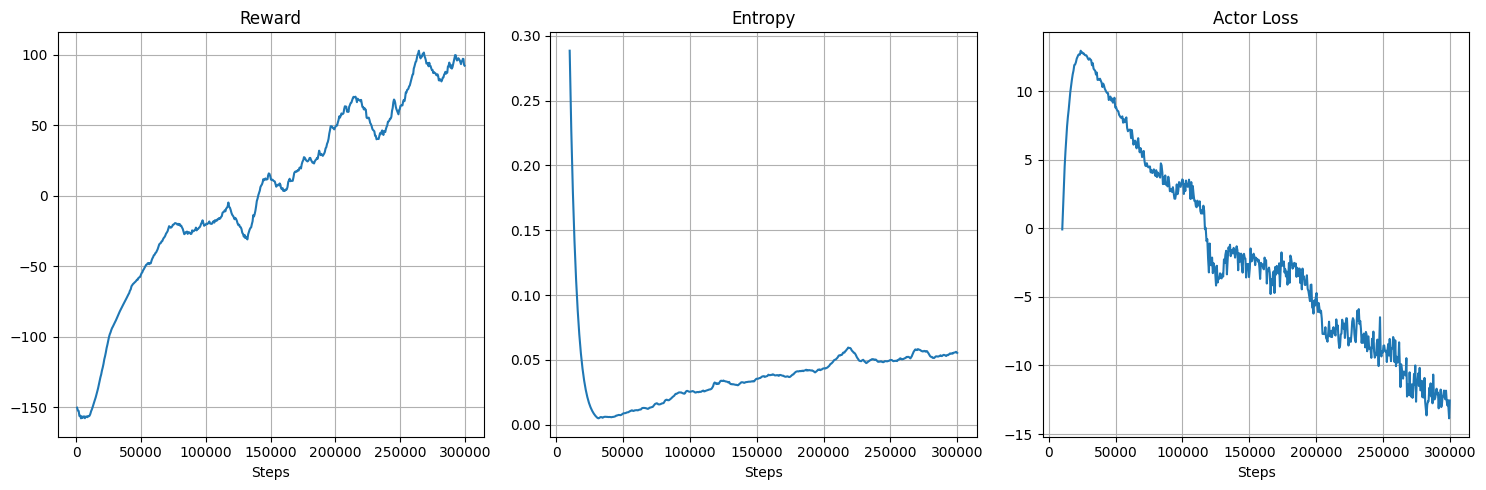

In [ ]:
plot_sac_metrics_from_tensorboard("/content/sac_tensorboardV"+version+".zip")

# Visualisation

### 1 episode

In [ ]:
def record_episode_with_frames(
    model_path="modelSAC3BoiteGripper",
    env=None,
    video_path="simulation.mp4",
    fps=30,
    max_steps=200,
    target_id=1
):
    assert env is not None, "Tu dois fournir un environnement déjà initialisé."

    obs, _ = env.reset()
    env.switch_target(new_target_id=target_id)

    model = SAC.load(model_path, device="cpu")
    frames = []

    for _ in range(env.max_steps):
        width, height, rgb, _, _ = p.getCameraImage(
            width=640,
            height=480,
            viewMatrix=p.computeViewMatrix(
                cameraEyePosition=[1.5, -1.2, 0.9],
                cameraTargetPosition=[0.6, 0.3, 0.4],
                cameraUpVector=[0, 0, 1]
            ),
            projectionMatrix=p.computeProjectionMatrixFOV(
                fov=50,
                aspect=640/480,
                nearVal=0.1,
                farVal=2.0
            )
        )
        frame = np.reshape(rgb, (height, width, 4))[:, :, :3]
        frames.append(frame)

        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
        time.sleep(1/240)

    imageio.mimsave(video_path, frames, fps=fps)
    print(f"Vidéo enregistrée : {video_path} ({len(frames)} frames, {len(frames)/fps:.1f} sec)")


In [ ]:
# Connexion PyBullet en amont
if p.isConnected():
    p.disconnect()
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Création de l'environnement global persistant
env = pandaReachFixedEnv(max_steps=200, training=False)

# Appel répétable à ta fonction vidéo
record_episode_with_frames(env=env, video_path="sim0.mp4", target_id=0, model_path=save_model_path)

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Nouvel épisode - Cible 0 (position: [0.6  0.   0.02])
phase 1
phase 2
phase 3
phase 4
Done
Vidéo enregistrée : sim0.mp4 (116 frames, 3.9 sec)


In [ ]:
Video("sim0.mp4", embed=True)


### Séquence de cibles en environnement reset

In [ ]:
# Connexion PyBullet en amont
if p.isConnected():
    p.disconnect()
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Création de l'environnement persistant
env = pandaReachFixedEnv(max_steps=150, training=True)

# Chargement du modèle SAC entraîné
model = SAC.load(save_model_path + ".zip")

# Séquence d'objectifs
sequence = [0, 1, 0, 2, 2, 1]

# Initialiser une liste pour stocker toutes les frames
all_frames = []

# Enregistrer toutes les frames
for target_id in sequence:
    env.switch_target(new_target_id=target_id)
    obs, _ = env.reset()

    done = False
    truncated = False
    while not (done or truncated):
        # Utilise le modèle pour prédire l'action
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        frame = env.render()
        if frame is not None:
            all_frames.append(frame)

# Maintenant sauver toutes les frames en une seule vidéo
if all_frames:
    height, width, _ = all_frames[0].shape
    out = cv2.VideoWriter("final_video_reset.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

    for frame in all_frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)

    out.release()

print("✅ Vidéo enregistrée sous 'final_video_reset.mp4'.")


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Nouvel épisode - Cible 0 (position: [0.6  0.   0.02])
phase 1
phase 2
phase 3
phase 4
Done
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
phase 1
phase 2
phase 3
phase 4
Done
Nouvel épisode - Cible 0 (position: [0.6  0.   0.02])
phase 1
phase 2
phase 3
raté, hauteur = 0.027862009
Nouvel épisode - Cible 2 (position: [0.6  0.   0.02])
phase 1
phase 2
phase 3
raté, hauteur = 0.076250225
Nouvel épisode - Cible 2 (position: [0.6  0.   0.02])
phase 1
phase 2
phase 3
phase 4
Done
Nouvel épisode - Cible 1 (position: [0.6  0.   0.02])
phase 1
phase 2
phase 3
phase 4
Done
✅ Vidéo enregistrée sous 'final_video_reset.mp4'.


### Séquence de cibles en environnement continu

In [ ]:
# Connexion PyBullet en amont
if p.isConnected():
    p.disconnect()
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Création de l'environnement persistant
env = pandaReachFixedEnv(max_steps=150, training=False)

# Chargement du modèle SAC entraîné
model = SAC.load(save_model_path + ".zip")

# Séquence d'objectifs
sequence = [0, 1, 0, 2, 2, 1]

# Initialiser une liste pour stocker toutes les frames
all_frames = []

# Enregistrer toutes les frames
for target_id in sequence:
    env.switch_target(new_target_id=target_id)
    obs, _ = env.reset()

    done = False
    truncated = False
    while not (done or truncated):
        # Utilise le modèle pour prédire l'action
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        frame = env.render()
        if frame is not None:
            all_frames.append(frame)

# Maintenant sauver toutes les frames en une seule vidéo
if all_frames:
    height, width, _ = all_frames[0].shape
    out = cv2.VideoWriter("final_video_continu.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

    for frame in all_frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)

    out.release()

print("✅ Vidéo enregistrée sous 'final_video_continu.mp4'.")


Nouvel épisode - Cible 0 (position: [ 0.6  -0.2   0.02])
phase 1
phase 2
phase 3
raté, hauteur = 0.08807466
Nouvel épisode - Cible 1 (position: [5.9999806e-01 5.0803199e-05 1.9988606e-02])
phase 1
phase 2
phase 3
phase 4
Done
Nouvel épisode - Cible 0 (position: [ 0.5900565  -0.19750823  0.01998937])
phase 1
phase 2
phase 3
phase 4
Done
Nouvel épisode - Cible 2 (position: [0.59999776 0.20013157 0.01998861])
Nouvel épisode - Cible 2 (position: [0.59466034 0.29146764 0.01998917])
Nouvel épisode - Cible 1 (position: [0.6961251  0.12042212 0.01998916])
phase 1
phase 2
✅ Vidéo enregistrée sous 'final_video_continu.mp4'.
